In [0]:
# Automatically reload external libraries that change
%reload_ext autoreload
%autoreload 2

# If a matplotlib plot command is issued, display the results in the notebook
%matplotlib inline

In [3]:
# Upload data
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [4]:
!tar xvzf track_shower_images.tar.gz

Images/
Images/Hits/
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_0_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_100_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_101_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_102_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_103_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_104_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_105_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_106_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_107_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_108_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_109_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_10_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_110_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_111_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_112_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_113_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_114_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_115_0.png
Images/Hits/Image_DUNEFD_MC1

In [0]:
# Reduce to just 100 images
#!rm -f Images/Truth/Image*_[0-9][0-9][0-9]_0.png
#!rm -f Images/Hits/Image*_[0-9][0-9][0-9]_0.png
#!rm -f *.py

In [7]:
# Upload supporting python modules
!rm -f *.py
from google.colab import files
files.upload()
from data import SegmentationBunch
from transforms import Rescale, ToTensor
from unet import UNet
import img_util as iu
import model_util as mu

Saving data.py to data.py
Saving img_util.py to img_util.py
Saving model_util.py to model_util.py
Saving transforms.py to transforms.py
Saving unet.py to unet.py


In [0]:
from data import open_image
img = open_image("Images/Truth/Image_DUNEFD_MC11_CaloHitListW_0_0.png")

In [9]:
img.size

(512, 208)

In [0]:
from torchvision import transforms
from torch.autograd import Variable
import torch
import torch.optim as opt
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [0]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
#bunch = SegmentationBunch("Images", "Hits", "Truth", batch_size=64, valid_pct = 0.2,
#    transform=transforms.Compose([Rescale((512, 208)), ToTensor()]))
bunch = SegmentationBunch("Images", "Hits", "Truth", batch_size=48, valid_pct = 0.2,
    transform=transforms.Compose([ToTensor(True)]))

In [0]:
count = {0: 0, 1: 0, 2: 0}
for batch in bunch.train_dl:
    images, masks = batch
    unique, counts = torch.unique(masks, return_counts=True)
    unique = [ u.item() for u in unique ]
    counts = [ c.item() for c in counts ]
    this_dict = dict(zip(unique, counts))
    for key in this_dict:
            count[key] += this_dict[key]

In [13]:
count
# There are 95973 shower hits and 127659 track hits in the training data set (last batch dropped)

{0: 81565296, 1: 95973, 2: 127659}

In [0]:
count = {0: 0, 1: 0, 2: 0}
for batch in bunch.valid_dl:
    images, masks = batch
    unique, counts = torch.unique(masks, return_counts=True)
    unique = [ u.item() for u in unique ]
    counts = [ c.item() for c in counts ]
    this_dict = dict(zip(unique, counts))
    for key in this_dict:
            count[key] += this_dict[key]

In [15]:
count
# Theere are 22308 shower hits and 32958 track hits in the validation set (relatively more tracks)

{0: 20392879, 1: 22073, 2: 32280}

In [0]:
void_code = 0

def accuracy(input, truth):
    target = truth.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

SHOWER = 1
TRACK = 2
def type_accuracy(input, truth, type):
    target = truth.squeeze(1)
    mask = target == type
    #print("Target shape:", target.shape)
    #print("Mask shape:", mask.shape)
    typestr = "SHOWER" if type == SHOWER else "TRACK"
    #print(f"Num mask {typestr} = {torch.sum(mask)}")
    #print(f"Num input {typestr} = {torch.sum(input.argmax(dim=1)[target != void_code] == type)}")
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

# Write some unit tests for this function using numpy arrays to check it is
# behaving correctly - get the shape of input and target to match dimensionality

In [28]:
# Create the network, loss function and optimizer
n_classes = 3
model = UNet(1, n_classes = n_classes, n_filters = 16, y_range = (0, n_classes))
#print(model)
num_shower_hits = 95973.0
num_track_hits = 127659.0
# Invert weighting to balance affect on loss function
shower_weight = num_track_hits / (num_shower_hits + num_track_hits)
track_weight = num_shower_hits / (num_shower_hits + num_track_hits)
print("Weights:", shower_weight, track_weight)
loss_fn = nn.CrossEntropyLoss(torch.tensor([0., shower_weight, track_weight]))
#optim = opt.Adam(model.parameters())
#optim = opt.Adam(model.parameters(), lr=2e-4)
#optim = opt.Adam(model.parameters(), lr=1e-4)
# Smoothest training, consistent with lr_finder
#optim = opt.Adam(model.parameters(), lr=1.5e-4)
#optim = opt.Adam(model.parameters(), lr=1.5e-4, weight_decay=0.1)
# New but untested, may also want to add weight decay to lr_finder,
# Might be worth testing a max of 2e-3 as well
#max_lr = 1e-3
max_lr = 1e-3
optim = opt.Adam(model.parameters(), lr=max_lr, weight_decay=0.1)
from torch.optim.lr_scheduler import OneCycleLR
# Want a cleaner way to get the number of batches
num_epochs = 1
#scheduler = OneCycleLR(optim, max_lr, total_steps=len(bunch.train_dl) * num_epochs)
#scheduler = OneCycleLR(optim, max_lr, total_steps=len(bunch.train_dl) * num_epochs, div_factor=10.0)
#scheduler = OneCycleLR(optim, max_lr, total_steps=len(bunch.train_dl) * num_epochs, div_factor=10.0)
#scheduler = OneCycleLR(optim, max_lr, total_steps=len(bunch.train_dl) * num_epochs, div_factor=2.0)
#scheduler = OneCycleLR(optim, max_lr*10, total_steps=len(bunch.train_dl) * num_epochs, pct_start=0.2, div_factor=10.0)
scheduler = OneCycleLR(optim, max_lr * 2, anneal_strategy='linear', epochs=num_epochs, steps_per_epoch=len(bunch.train_dl), pct_start=0.05, div_factor=2.0)
# maybbe change final_div_factor too, because div by 10K is probably massive overkill for short runs
# Temp scheduler to not change rate
#from torch.optim.lr_scheduler import LambdaLR
#scheduler = LambdaLR(optim, lambda epoch: 10.)

Weights: 0.5708440652500537 0.42915593474994634


In [0]:
# Find learning rate
#optim = opt.Adam(model.parameters(), lr=1e-7)
#num_iter = 100
#lr_lambda = lambda batch : get_running_factor(1e-7, 10, num_iter, batch)
min_lr = 1e-5
max_lr = 1
optim = opt.Adam(model.parameters(), lr=min_lr)
num_iter = 40
lr_lambda = lambda batch : get_running_factor(min_lr, max_lr, num_iter, batch)
lr_finder = mu.LRFinder(optim=optim, num_iter=num_iter)
lr_finder.find(model=model, input=bunch.train_dl, loss_fn=loss_fn)

In [0]:
learning_rates = lr_finder.get_learning_rates()
train_loss_epochs = lr_finder.get_losses()

In [0]:
print(learning_rates)

In [0]:
def plot_lr(x, y, name, labels=("lr", "Loss")):
    fig, ax = plt.subplots()
    ax.set_title('Learning Rate Finder')
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.plot(x, y, c='darkred')
    iu.save_figure(fig, name)

In [0]:
plot_lr(learning_rates, train_loss_epochs, "LossByLearningRate")
plot_lr(learning_rates[:55], train_loss_epochs[:55], "LossByLearningRate")
plot_lr(list(range(len(learning_rates))), train_loss_epochs, "LossByLearningRate", ("Batch", "Loss"))

In [0]:
!tar cvzf images.tar.gz *.png *.pdf *.eps

LossByBatch.png
LossByLearningRate.png
LossByLearningRateZoom.png
LossByBatch.pdf
LossByLearningRate.pdf
LossByLearningRateZoom.pdf
LossByBatch.eps
LossByLearningRate.eps
LossByLearningRateZoom.eps


In [0]:
files.download("images.tar.gz")

In [0]:
class EpochStats:
    def __init__(self, classes=[SHOWER, TRACK]):
        self.loss = []
        self.accuracy = []
        self.class_accuracy = { key : [] for key in classes }

    def add_loss(self, loss):
        self.loss.append(loss)
    
    def add_accuracy(self, acc, cls=None):
        if cls is None:
            self.accuracy.append(acc)
        else:
            self.class_accuracy[cls].append(acc)

    def get_losses(self):
        return np.array(self.loss)
    
    def get_accuracies(self, cls=None):
        if cls is None:
            return np.array(self.accuracy)
        else:
            return np.array(self.class_accuracy[cls])

class TrainingInfo:
    def __init__(self):
        self.learning_rates = []

def one_epoch(epoch, model, optim, scheduler, dl, training):
    stats = EpochStats()
    info = TrainingInfo()
    for i, batch in enumerate(dl):
        images, masks = batch
        x = Variable(images)
        y = Variable(masks)
        pred = model.forward(x)

        loss = loss_fn(pred, y)
        stats.add_loss(loss.item())

        acc = accuracy(pred, y)
        track_acc = type_accuracy(pred, y, TRACK)
        shower_acc = type_accuracy(pred, y, SHOWER)
        stats.add_accuracy(acc)
        stats.add_accuracy(track_acc, TRACK)
        stats.add_accuracy(shower_acc, SHOWER)

        # Just one learning rate for now
        info.learning_rates.append(scheduler.get_lr()[0])

        if i == (len(dl) - 1):
            net_input = x.detach().numpy()
            net_pred = pred.detach().numpy()
            net_mask = y.detach().numpy()
            iu.show_batch(epoch, i, net_input, net_pred, net_mask, void_code, n=3, randomize=True)
        
        print("Batch {} [{}]: Train Loss: {}   Train Acc: {}   S Acc: {} T Acc: {}".format(
            i + 1, info.learning_rates[-1], loss.item(), acc, shower_acc, track_acc))

        if training:
            loss.backward()
            optim.step()
            scheduler.step()
            optim.zero_grad()
    return stats, info

***Training***
Target shape: torch.Size([48, 208, 512])
Mask shape: torch.Size([48, 208, 512])
Num mask TRACK = 9279
Num input TRACK = 10334
Target shape: torch.Size([48, 208, 512])
Mask shape: torch.Size([48, 208, 512])
Num mask SHOWER = 6864
Num input SHOWER = 4748
Batch 1 [0.0019736855263157893]: Train Loss: 1.160952091217041   Train Acc: 0.511924684047699   S Acc: 0.30463287234306335 T Acc: 0.665265679359436
Target shape: torch.Size([48, 208, 512])
Mask shape: torch.Size([48, 208, 512])
Num mask TRACK = 8419
Num input TRACK = 8144
Target shape: torch.Size([48, 208, 512])
Mask shape: torch.Size([48, 208, 512])
Num mask SHOWER = 6269
Num input SHOWER = 6539
Batch 2 [0.0018421131578947368]: Train Loss: 0.6835358142852783   Train Acc: 0.6989378929138184   S Acc: 0.6691657304763794 T Acc: 0.721107006072998
Target shape: torch.Size([48, 208, 512])
Mask shape: torch.Size([48, 208, 512])
Num mask TRACK = 6231
Num input TRACK = 4677
Target shape: torch.Size([48, 208, 512])
Mask shape: torch

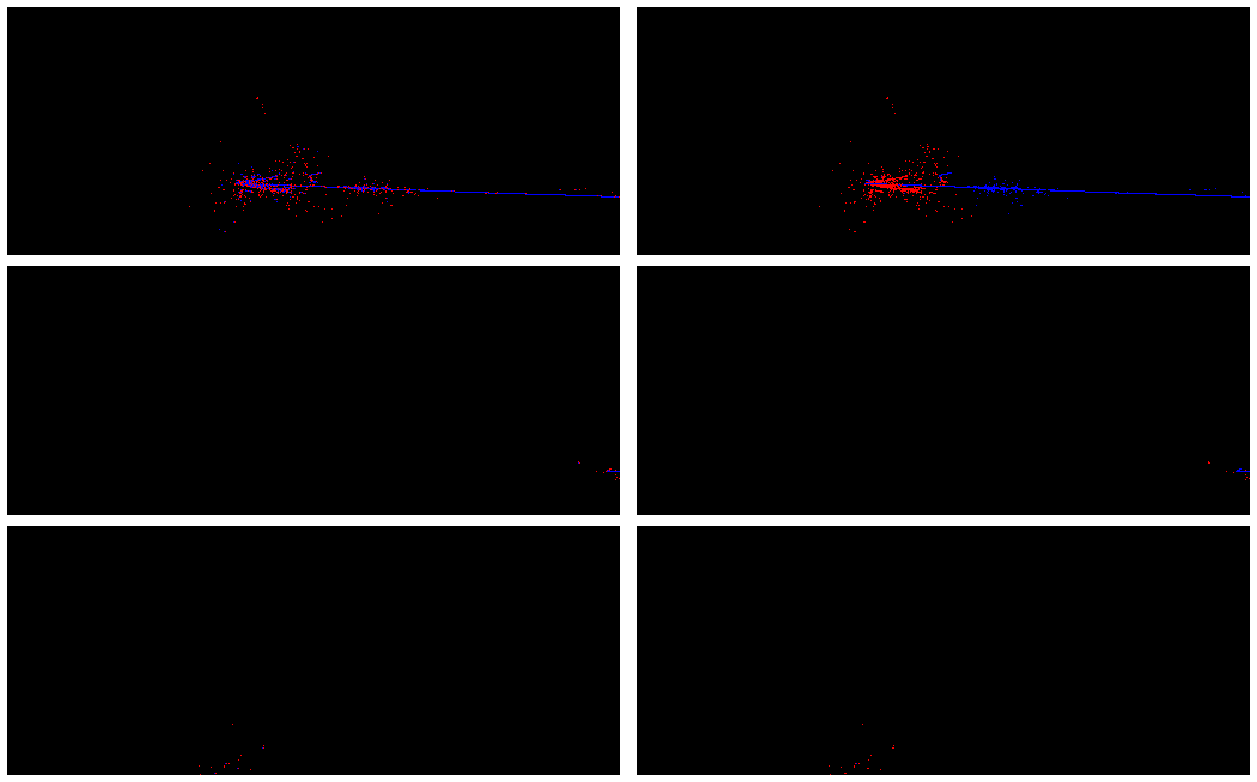

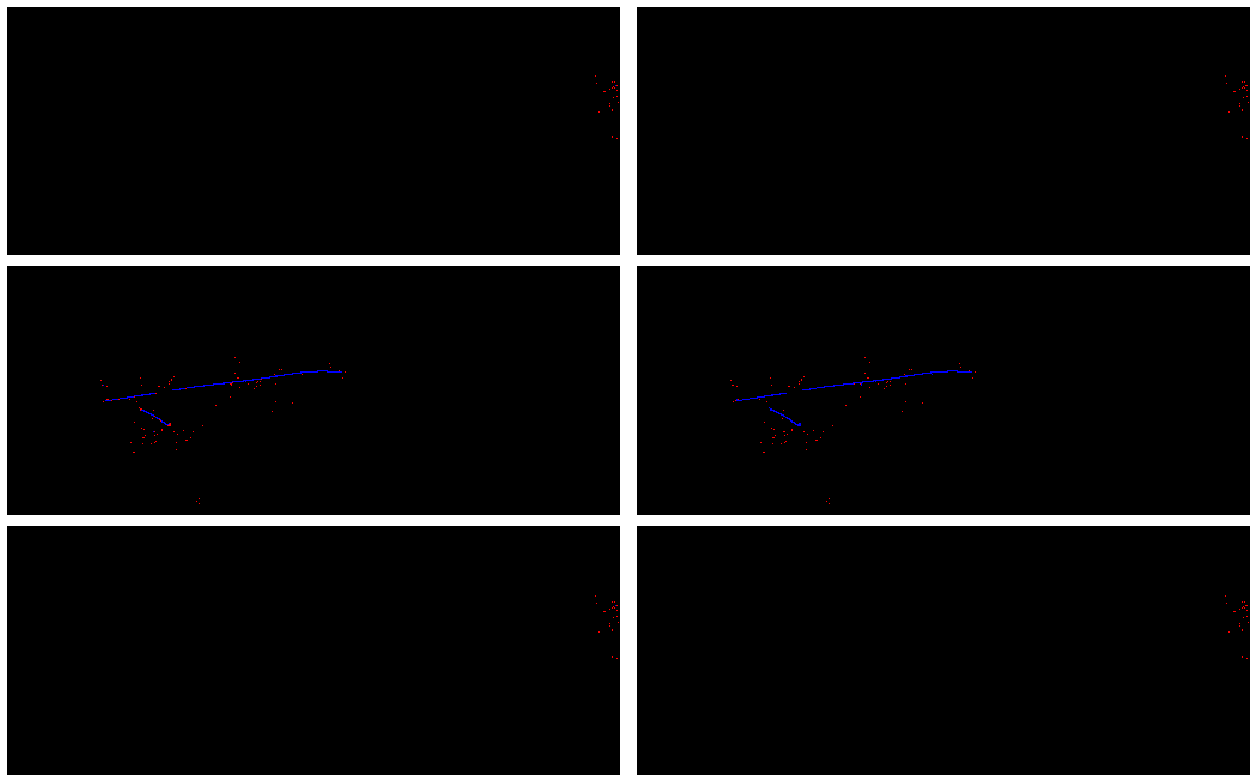

In [31]:
# Run
learning_rates = []
train_loss_epochs = []
train_acc_epochs = []
val_loss_epochs = []
val_acc_epochs = []
for epoch in list(range(0, num_epochs)):
    # Training
    print("***Training***")
    model = model.train()
    optim.zero_grad()
    stats, info = one_epoch(epoch, model, optim, scheduler, bunch.train_dl, True)
    train_loss_epochs.append(stats.get_losses().mean())
    train_acc_epochs.append(stats.get_accuracies().mean())
    learning_rates += info.learning_rates
    # Validation
    print("***Validating***")
    model = model.eval()

    for group in model.children():
        if type(group) == nn.Sequential:
            for child in group:
                if type(child)==nn.BatchNorm2d:
                    child.track_running_stats = False

    with torch.no_grad():
        val_stats, _ = one_epoch(epoch, model, optim, scheduler, bunch.valid_dl, False)
        val_loss_epochs.append(val_stats.get_losses().mean())
        val_acc_epochs.append(val_stats.get_accuracies().mean())
    print("Epoch {} : loss {} acc {}   val_loss {} val_acc {}:".format(
        epoch + 1, stats.get_losses().mean(), stats.get_accuracies().mean(),
        val_stats.get_losses().mean(), val_stats.get_accuracies().mean()))

Target shape: torch.Size([48, 208, 512])
Mask shape: torch.Size([48, 208, 512])
Num mask TRACK = 8538
Num input TRACK = 11373
Target shape: torch.Size([48, 208, 512])
Mask shape: torch.Size([48, 208, 512])
Num mask SHOWER = 7793
Num input SHOWER = 4724
Batch 1 [0.0017105407894736843]: Train Loss: 0.7916115522384644   Train Acc: 0.6576449871063232   S Acc: 0.4507891833782196 T Acc: 0.8464511632919312
Target shape: torch.Size([48, 208, 512])
Mask shape: torch.Size([48, 208, 512])
Num mask TRACK = 6389
Num input TRACK = 9242
Target shape: torch.Size([48, 208, 512])
Mask shape: torch.Size([48, 208, 512])
Num mask SHOWER = 4685
Num input SHOWER = 1832
Batch 2 [0.0015789684210526316]: Train Loss: 0.6987192034721375   Train Acc: 0.6762687563896179   S Acc: 0.31291356682777405 T Acc: 0.9427140355110168
Target shape: torch.Size([48, 208, 512])
Mask shape: torch.Size([48, 208, 512])
Num mask TRACK = 6089
Num input TRACK = 9078
Target shape: torch.Size([48, 208, 512])
Mask shape: torch.Size([48, 

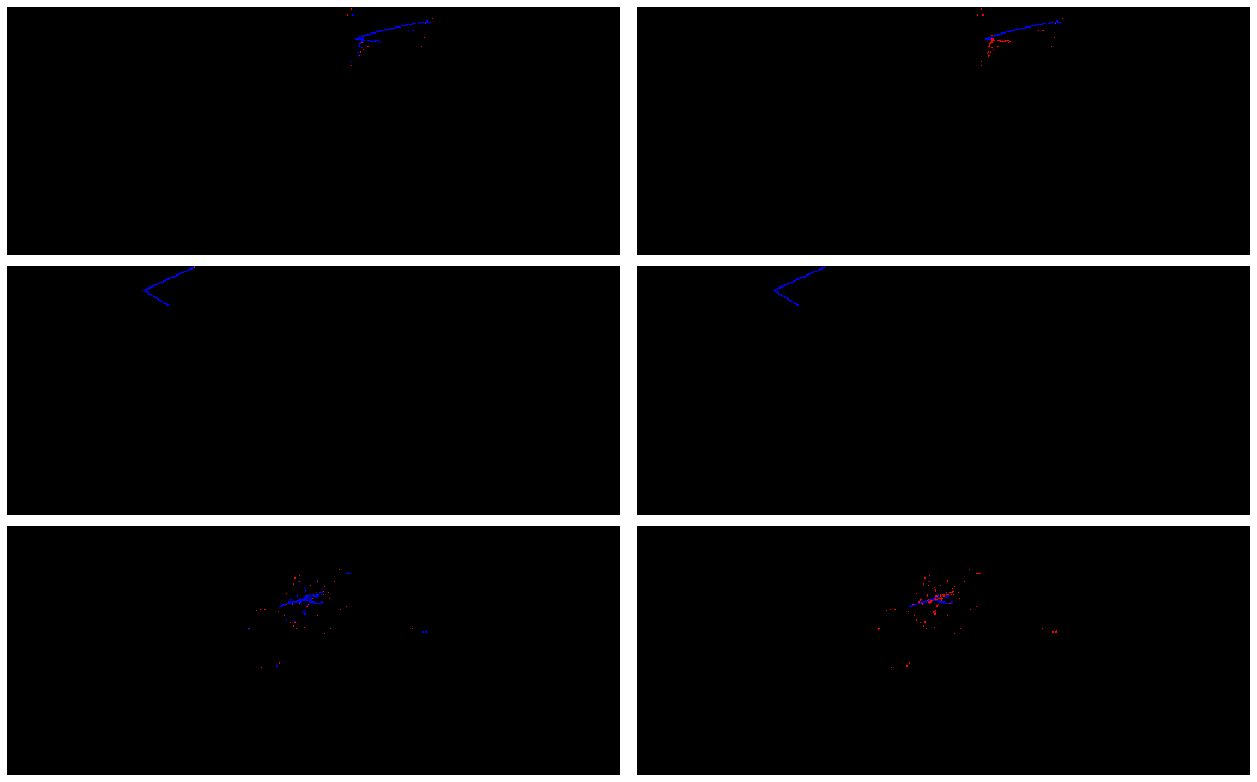

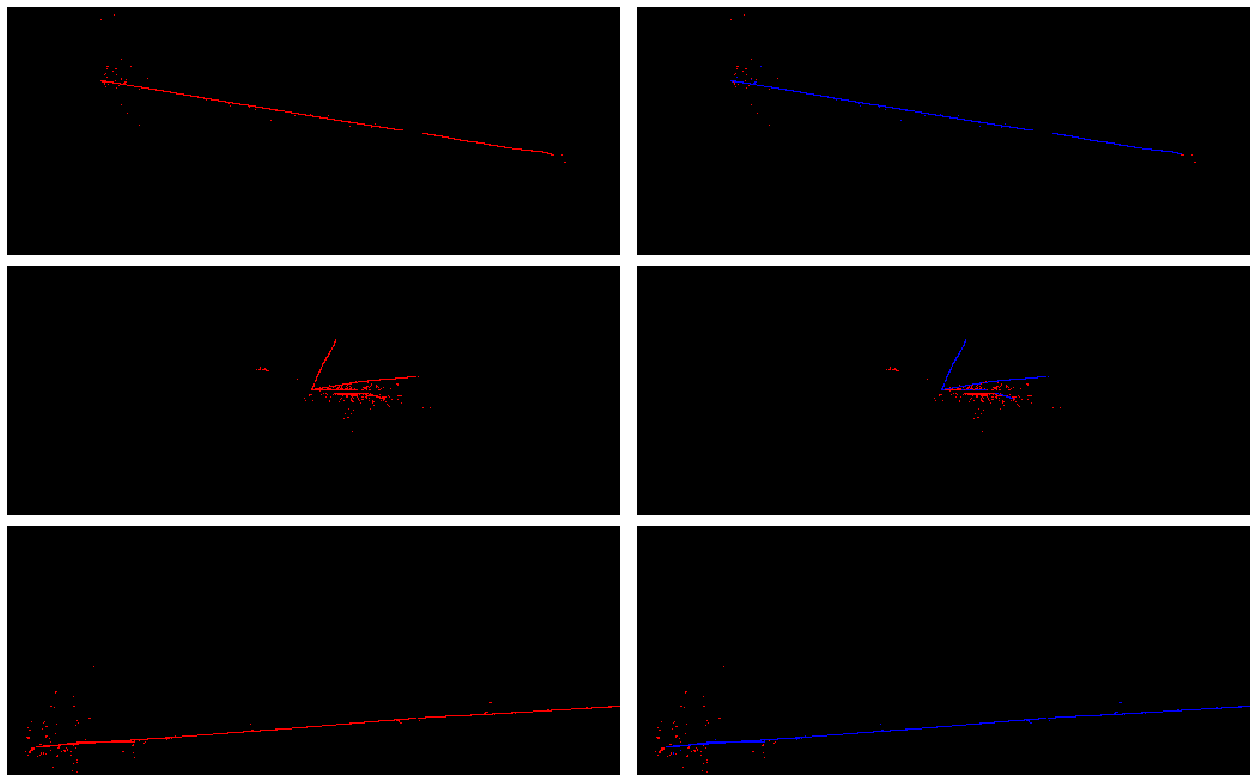

In [19]:
# Run
learning_rates = []
train_loss_epochs = []
train_acc_epochs = []
train_loss_batches = []
train_acc_batches = []
val_loss_epochs = []
val_acc_epochs = []
val_loss_batches = []
val_acc_batches = []
for epoch in list(range(0, num_epochs)):
    # Training
    model.train()
    optim.zero_grad()
    train_dl = bunch.train_dl
    losses = np.zeros(len(train_dl))
    accuracies = np.zeros(len(train_dl))
    for i, batch in enumerate(train_dl):
        images, masks = batch
        x = Variable(images)
        y = Variable(masks)
        pred = model.forward(x)

        loss = loss_fn(pred, y)
        losses[i] = loss.item()
        train_loss_batches.append(losses[i])

        acc = accuracy(pred, y)
        accuracies[i] = acc
        train_acc_batches.append(accuracies[i])

        track_acc = type_accuracy(pred, y, TRACK)
        shower_acc = type_accuracy(pred, y, SHOWER)

        # Just one learning rate for now
        learning_rates.append(scheduler.get_lr()[0])

        if i == 5:#(len(train_dl) - 1):
            net_input = x.detach().numpy()
            net_pred = pred.detach().numpy()
            net_mask = y.detach().numpy()
            iu.show_batch(epoch, i, net_input, net_pred, net_mask, void_code, n=3, randomize=True)
        
        print("Batch {} [{}]: Train Loss: {}   Train Acc: {}   S Acc: {} T Acc: {}".format(
            i + 1, learning_rates[-1], losses[i], accuracies[i], shower_acc, track_acc))

        loss.backward()
        optim.step()
        scheduler.step()
        optim.zero_grad()
        if i == 5: break
    train_loss_epochs.append(losses.mean())
    train_acc_epochs.append(accuracies.mean())
    # Validation
    model.eval()
    valid_dl = bunch.valid_dl
    val_losses = np.zeros(len(valid_dl))
    val_accuracies = np.zeros(len(valid_dl))
    with torch.no_grad():
        for i, batch in enumerate(valid_dl):
            images, masks = batch
            x = Variable(images)
            y = Variable(masks)
            pred = model.forward(x)
            loss = loss_fn(pred, y)
            val_losses[i] = loss.item()
            val_loss_batches.append(val_losses[i])

            acc = accuracy(pred, y)
            val_accuracies[i] = acc
            val_acc_batches.append(val_accuracies[i])

            track_acc = type_accuracy(pred, y, TRACK)
            shower_acc = type_accuracy(pred, y, SHOWER)

            print(f"Batch {i + 1}: Val Loss: {val_losses[i]}   Val Acc: {val_accuracies[i]}   S Acc: {shower_acc} T Acc: {track_acc}")

            if i == 0:#(len(valid_dl) - 1):
                net_input = x.detach().numpy()
                net_pred = pred.detach().numpy()
                net_mask = y.detach().numpy()
                iu.show_batch(5, i, net_input, net_pred, net_mask, void_code, n=3, randomize=True)
                break
    val_loss_epochs.append(val_losses.mean())
    val_acc_epochs.append(val_accuracies.mean())
    print("Epoch {} : loss {} acc {}   val_loss {} val_acc {}:".format(
        epoch + 1, losses.mean(), accuracies.mean(),
        val_losses.mean(), val_accuracies.mean()))

In [0]:
def plot_lr_loss_acc(lrs, losses, accuracies, name):
    fig, axs = plt.subplots(3, 1, sharex=True)
    xx = list(range(1, 1 + len(lrs)))
    yy = [lrs, losses, accuracies]
    labels = ["lr", "loss", "acc"]
    colors = ['darkred', 'green', 'blue']
    for i, ax in enumerate(axs):
        ax.set_xlabel("Batch")
        ax.set_ylabel(labels[i])
        ax.plot(xx, yy[i], c=colors[i])
    for ax in axs: ax.label_outer()
    plt.tight_layout()
    iu.save_figure(fig, name)

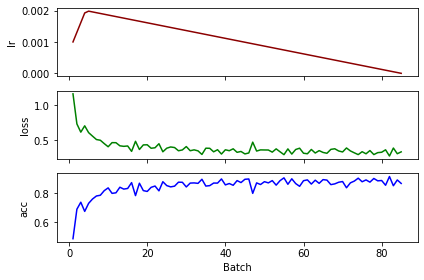

In [0]:
plot_lr_loss_acc(learning_rates, train_loss_batches, train_acc_batches, "LRLossAcc")

In [0]:
cycle_lr = learning_rates
cycle_losses = train_loss_batches
cycle_acc = train_acc_batches

In [0]:
# Upload pickle files
from google.colab import files
files.upload()

Saving flat_acc.npy to flat_acc.npy
Saving flat_losses.npy to flat_losses.npy
Saving flat_lr.npy to flat_lr.npy


{'flat_acc.npy': b"\x93NUMPY\x01\x00v\x00{'descr': '<f8', 'fortran_order': False, 'shape': (85,), }                                                           \n\x00\x00\x00`;\x8f\xe0?\x00\x00\x00`\x84\x1b\xe4?\x00\x00\x00\x80_r\xe7?\x00\x00\x00`=\xa3\xe6?\x00\x00\x00\x80\xbcU\xe7?\x00\x00\x00\x00\x1c\x88\xe8?\x00\x00\x00 Q9\xe8?\x00\x00\x00`\x00\xa1\xe8?\x00\x00\x00\xc0\xa5a\xea?\x00\x00\x00@\x10\xd5\xe9?\x00\x00\x00 c#\xe9?\x00\x00\x00\xe0\xae\x8b\xea?\x00\x00\x00\x80$\x80\xe9?\x00\x00\x00 \x03\xa6\xe9?\x00\x00\x00\xa0\x7f\xf7\xe9?\x00\x00\x00 \xb0o\xe9?\x00\x00\x00\xa0\xbfv\xea?\x00\x00\x00\xe08\x05\xea?\x00\x00\x00`\x1e\x90\xea?\x00\x00\x00\xa0?.\xeb?\x00\x00\x00\x80m\xbc\xea?\x00\x00\x00 \xec\xec\xe9?\x00\x00\x00\xc0\xdd\x16\xea?\x00\x00\x00 \xa2F\xea?\x00\x00\x00\x80\xa5\x16\xeb?\x00\x00\x00 \x91\xb9\xeb?\x00\x00\x00`\xd5\x99\xeb?\x00\x00\x00\x00q\xc0\xeb?\x00\x00\x00\xe0\xb9n\xeb?\x00\x00\x00`\x01h\xe9?\x00\x00\x00 \x84\r\xec?\x00\x00\x00 Ue\xec?\x00\x00\x00\x00\x92\x1e\xea?\x00\

In [0]:
import numpy as np
learning_rates = np.load("flat_lr.npy")
train_loss_batches = np.load("flat_losses.npy")
train_acc_batches = np.load("flat_acc.npy")

In [0]:
# Upload pickle files
!rm -f cycle_*.npy 
from google.colab import files
files.upload()

Saving cycle_acc.npy to cycle_acc.npy
Saving cycle_losses.npy to cycle_losses.npy
Saving cycle_lr.npy to cycle_lr.npy


{'cycle_acc.npy': b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<f8\', \'fortran_order\': False, \'shape\': (85,), }                                                           \n\x00\x00\x00\x80\x8f\x0b\xdf?\x00\x00\x00\xc0\xc8\x0c\xe6?\x00\x00\x00\xa0Z\x8b\xe7?\x00\x00\x00`R\x82\xe5?\x00\x00\x00`\xdc+\xe7?\x00\x00\x00\xc0\x99b\xe8?\x00\x00\x00\x00&\xe3\xe8?\x00\x00\x00@\xf6N\xe9?\x00\x00\x00\xc0\xefN\xea?\x00\x00\x00\xc0\xbd.\xeb?\x00\x00\x00 \x98C\xea?\x00\x00\x00@(\x01\xea?\x00\x00\x00\x00\x84\x96\xeb?\x00\x00\x00\xe02W\xeb?\x00\x00\x00 \xce\x13\xea?\x00\x00\x00\x00\x16\xbc\xeb?\x00\x00\x00\x00\x8f^\xe6?\x00\x00\x00 \xe1N\xeb?\x00\x00\x00@U\xe0\xe9?\x00\x00\x00 ~\xc4\xe9?\x00\x00\x00\x80\x97;\xea?\x00\x00\x00\x80\x18.\xea?\x00\x00\x00\x80W\\\xe8?\x00\x00\x00\x00&$\xeb?\x00\x00\x00`\xf29\xea?\x00\x00\x00\xa0O"\xea?\x00\x00\x00`\x9f\xc0\xea?\x00\x00\x00 \xceW\xeb?\x00\x00\x00\xa0D\xff\xe9?\x00\x00\x00 <\xfe\xe9?\x00\x00\x00@o\xa2\xeb?\x00\x00\x00\x80\xcb\x86\xeb?\x00\x00\x00@M\x10\xeb?\x00\x00

In [0]:
cycle_lr = np.load("cycle_lr.npy")
cycle_losses = np.load("cycle_losses.npy")
cycle_acc = np.load("cycle_acc.npy")

In [0]:
def plot_multi_lr_loss_acc(lrs, losses, accuracies, lrs2, losses2, acc2, name):
    fig, axs = plt.subplots(2, 1, sharex=True)
    xx = list(range(1, 1 + len(lrs)))
    yy_flat = [lrs, losses, accuracies]
    yy_cycle = [lrs2, losses2, acc2]
    xlabels = ["lr", "loss", "acc"]
    labels = ["Constant", "One-Cycle"]
    colors = [['black', 'black', 'black'],['red', 'red', 'red']]
    for i, ax in enumerate(axs):
        ax.set_xlabel("Batch")
        ax.set_ylabel(xlabels[i])
        ax.plot(xx, yy_flat[i], c=colors[0][i], label=labels[0])
        ax.plot(xx, yy_cycle[i], c=colors[1][i], label=labels[1])
    axs[0].legend()
    for ax in axs: ax.label_outer()
    plt.tight_layout()
    iu.save_figure(fig, name)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


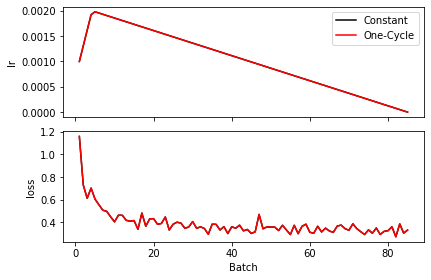

In [0]:
plot_multi_lr_loss_acc(learning_rates, train_loss_batches, train_acc_batches, cycle_lr, cycle_losses, cycle_acc, "MultiLRLossAcc")

In [0]:
np.save("flat_lr", learning_rates)
np.save("flat_losses", train_loss_batches)
np.save("flat_acc", train_acc_batches)

In [0]:
np.save("cycle_lr", learning_rates)
np.save("cycle_losses", train_loss_batches)
np.save("cycle_acc", train_acc_batches)

In [0]:
!ls -l *

-rw-r--r-- 1 root   root     22372 Nov 26 15:08 AverageAccuracyVsTrainingEpoch.eps
-rw-r--r-- 1 root   root     12562 Nov 26 15:08 AverageAccuracyVsTrainingEpoch.pdf
-rw-r--r-- 1 root   root     17086 Nov 26 15:08 AverageAccuracyVsTrainingEpoch.png
-rw-r--r-- 1 root   root     24374 Nov 26 15:08 AverageLossVsTrainingEpoch.eps
-rw-r--r-- 1 root   root     13669 Nov 26 15:08 AverageLossVsTrainingEpoch.pdf
-rw-r--r-- 1 root   root     17817 Nov 26 15:08 AverageLossVsTrainingEpoch.png
-rw-r--r-- 1 root   root       808 Nov 26 15:21 cycle_acc.npy
-rw-r--r-- 1 root   root       808 Nov 26 15:21 cycle_losses.npy
-rw-r--r-- 1 root   root       808 Nov 26 15:21 cycle_lr.npy
-rw-r--r-- 1 root   root      3416 Nov 26 11:59 data.py
-rw-r--r-- 1 root   root   3503053 Nov 26 14:14 diagnostic_0_16.eps
-rw-r--r-- 1 root   root     12195 Nov 26 14:14 diagnostic_0_16.pdf
-rw-r--r-- 1 root   root      6843 Nov 26 14:14 diagnostic_0_16.png
-rw-r--r-- 1 root   root   3503053 Nov 26 14:25 diagnostic_1_16.ep

In [0]:
!ls -l *.png

-rw-r--r-- 1 root root 5680 Nov 22 11:41 diagnostic_0_16.png
-rw-r--r-- 1 root root 7782 Nov 22 11:49 diagnostic_1_16.png
-rw-r--r-- 1 root root 6817 Nov 22 11:58 diagnostic_2_16.png
-rw-r--r-- 1 root root 5445 Nov 22 12:06 diagnostic_3_16.png
-rw-r--r-- 1 root root 7847 Nov 22 12:15 diagnostic_4_16.png


In [0]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

In [0]:
dump_tensors()

Total size: 0


/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:101: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: MODES has been renamed to Modes and will be removed in a future version of pywt.


In [0]:
#del x, y
#del images, masks
#del model
torch.cuda.empty_cache()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


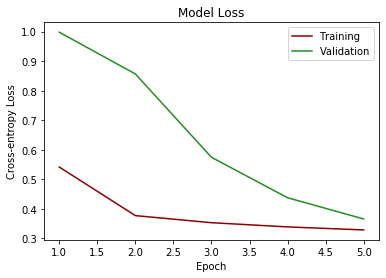

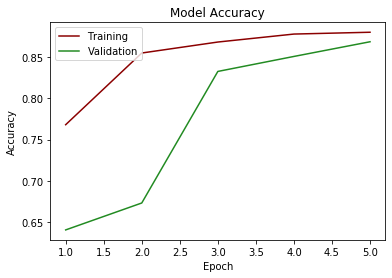

In [0]:
epoch_list = list(range(1, 6))
fig, ax = plt.subplots()
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-entropy Loss')
ax.plot(epoch_list, train_loss_epochs, label='Training', c='darkred')
ax.plot(epoch_list, val_loss_epochs, label='Validation', c='forestgreen')
ax.legend(loc='upper right')
iu.save_figure(plt, "AverageLossVsTrainingEpoch")

fig, ax = plt.subplots()
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.plot(epoch_list, train_acc_epochs, label='Training', c='darkred')
ax.plot(epoch_list, val_acc_epochs, label='Validation', c='forestgreen')
ax.legend(loc='upper left')
iu.save_figure(plt, "AverageAccuracyVsTrainingEpoch")

In [0]:
!tar cvzf images.tar.gz *.png *.pdf *.eps *.npy
files.download("images.tar.gz")

AverageAccuracyVsTrainingEpoch.png
AverageLossVsTrainingEpoch.png
diagnostic_5_0.png
diagnostic_5_1.png
diagnostic_5_2.png
diagnostic_5_3.png
LRLossAcc.png
MultiLRLossAcc.png
AverageAccuracyVsTrainingEpoch.pdf
AverageLossVsTrainingEpoch.pdf
diagnostic_5_0.pdf
diagnostic_5_1.pdf
diagnostic_5_2.pdf
diagnostic_5_3.pdf
LRLossAcc.pdf
MultiLRLossAcc.pdf
AverageAccuracyVsTrainingEpoch.eps
AverageLossVsTrainingEpoch.eps
diagnostic_5_0.eps
diagnostic_5_1.eps
diagnostic_5_2.eps
diagnostic_5_3.eps
LRLossAcc.eps
MultiLRLossAcc.eps
cycle_acc.npy
cycle_losses.npy
cycle_lr.npy


In [0]:
!ls -l

total 1736
-rw-r--r-- 1 root   root    22490 Nov 14 13:22  AverageAccuracyVsTrainingEpoch.png
-rw-r--r-- 1 root   root    19800 Nov 14 13:22  AverageLossVsTrainingEpoch.png
-rw-r--r-- 1 root   root     3416 Nov 14 12:29 'data (1).py'
-rw-r--r-- 1 root   root     3416 Nov 14 12:12  data.py
drwxr-xr-x 4 197608 197121   4096 Nov 14 08:36  Images
drwxr-xr-x 2 root   root     4096 Nov 14 12:12  __pycache__
drwxr-xr-x 1 root   root     4096 Nov  6 16:17  sample_data
-rw-r--r-- 1 root   root   840513 Nov 14 12:29 'track_shower_images.tar (1).gz'
-rw-r--r-- 1 root   root   840513 Nov 14 12:12  track_shower_images.tar.gz
-rw-r--r-- 1 root   root     1264 Nov 14 12:29 'transforms (1).py'
-rw-r--r-- 1 root   root     1264 Nov 14 12:12  transforms.py
-rw-r--r-- 1 root   root     4289 Nov 14 12:29 'unet (1).py'
-rw-r--r-- 1 root   root     4289 Nov 14 12:12  unet.py


In [0]:
inp = torch.FloatTensor(
    [[ [ [0, 0, 255] , [255, 0, 0] , [255, 0, 255] ] ,   # Class 0
     [ [0, 0, 0] , [0, 0, 0] , [0, 255, 0] ] ,   # Class 1
     [ [255, 255, 0] , [0, 255, 255] , [0, 0, 0] ] ]] )  # Class 2
prediction = torch.FloatTensor(
    [[ [ [0, 0, 255] , [255, 0, 0] , [255, 0, 255] ] ,   # Class 0
     [ [0, 255, 0] , [0, 0, 0] , [0, 255, 0] ] ,   # Class 1
     [ [255, 0, 0] , [0, 255, 255] , [0, 0, 0] ] ]] )  # Class 2
truth = torch.LongTensor([[
    [2, 2, 0 ], 
    [0, 2, 2 ],
    [0, 1, 0 ]]])

In [67]:
print(prediction.shape)
print(truth.shape)

torch.Size([1, 3, 3, 3])
torch.Size([1, 3, 3])


In [35]:
vals = iu.imagify(inp, prediction, truth, 0, n=1, randomize=False)

Input shape torch.Size([1, 3, 3])
Truth shape torch.Size([1, 3, 3])
Pred shape torch.Size([1, 3, 3, 3])
[[[2 1 0]
  [0 2 2]
  [0 1 0]]]
tensor([[[2, 2, 0],
         [0, 2, 2],
         [0, 1, 0]]])


In [0]:
inp, pred, tru = vals

In [39]:
print(pred.shape)
print(tru.shape)

(1, 3, 3)
torch.Size([1, 3, 3])


In [76]:
acc = accuracy(torch.FloatTensor(prediction), truth)
acc = track_accuracy(torch.FloatTensor(prediction), truth)
acc

Shape: torch.Size([1, 3, 3])
Target: tensor([[[2, 2, 0],
         [0, 2, 2],
         [0, 1, 0]]])
Mask: tensor([[[ True,  True, False],
         [False,  True,  True],
         [False,  True, False]]])
Masked pred: tensor([2, 1, 2, 2, 1])
Masked mask: tensor([2, 2, 2, 2, 1])


tensor(0.7500)

In [41]:
print(pred)
print(tru)

[[[2 1 0]
  [0 2 2]
  [0 1 0]]]
tensor([[[2, 2, 0],
         [0, 2, 2],
         [0, 1, 0]]])


In [20]:
np.linspace(0,2,4)

array([0.        , 0.66666667, 1.33333333, 2.        ])